## pitchfork_review_anlaysis
**Program:** 01_pitchfork_review_analysis.ipynb <br>
**Created by:** Chris Chan<br>
**Date:** Mar 16, 2021<br>
**Purpose:** <br>
. The purpose of the project is to develop a modern jazz artist recommender/discovery based on sub-genres or non-jazz artists somehow linked to the jazz album via pitchfork review text. Upon inspection of reviews (namely jazz reviews) there is high chance of other non-jazz artist referenced to shed light on some similarity. The idea is to take these links as features or search terms in a rec system that would link to the jazz artist. The jazz artists would be cmpared as well given various topics modeled from all of the reviews.

. 1. bring in data, count vectorize, etc. <br>
. 2. preprocessing - clean, lemmatize <br>
. 3. explore:<br>
    . Basic EDA
    . try topic modeling<br>
    . sentiment analysis<br>
    . combining the two<br>

In [1]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.decomposition import NMF

In [2]:
import glob
import os
from collections import defaultdict
import re
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd

In [3]:
import nltk
import os
import spacy
import re
import string
import pickle
from itertools import cycle
import matplotlib.pyplot as plt
from nltk import stem
%matplotlib inline
%config InlineBackend.figure_formats = ['retina']
from nltk.tokenize import word_tokenize, sent_tokenize, MWETokenizer
from gensim import corpora, models, similarities, matutils
from sklearn.decomposition import TruncatedSVD, NMF
from corextopic import corextopic, vis_topic
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
import plotly.graph_objects as go
import scattertext as st

In [4]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob

### Read in data

**We read through all the docments and build a list-of-list of words:**

In [950]:
df = pd.read_csv('/Users/chrischan/Documents/02_Class/Metis/bootcamp/githubrepo/Metis_proj5/data/pitchfork_jazz_clean.csv')

In [951]:
df.head()

,Unnamed: 0,artist,album,score,genre,review,othercat,othercat2,best,date,testing_formula
0,0,Sam Gendel,Fresh Bread,6.5,Jazz,"Fifty-two tracks deep, this archival compendiu...","['Skip to content', 'All Results', 'Home', 'Ne...","Sam Gendel, Jay Balfour, Sam Gendel, cover...",0,March 4 2021,"Skip to content, All Results, Home, News, Revi..."
1,1,Femi Kuti / Made Kuti,Legacy +,7.8,Global,"On the duo’s generation-spanning double album,...","['Skip to content', 'All Results', 'Home', 'Ne...","Femi Kuti, Made Kuti, Joey Akan, Global, F...",0,February 20 2021,"Skip to content, All Results, Home, News, Revi..."
2,2,Archie Shepp / Jason Moran,Let My People Go,7.5,Jazz,These live sets between the saxophonist and pi...,"['Skip to content', 'All Results', 'Home', 'Ne...","Archie Shepp, Jason Moran, Madison Bloom, ...",0,February 15 2021,"Skip to content, All Results, Home, News, Revi..."
3,3,Patricia Brennan,Maquishti,7.4,Experimental,"Challenging but never chaotic, contemplative y...","['Skip to content', 'All Results', 'Home', 'Ne...","Patricia Brennan, Daniel Felsenthal, Experime...",0,January 19 2021,"Skip to content, All Results, Home, News, Revi..."
4,4,Baldi/Gerycz Duo,After Commodore Perry Service Plaza,7.1,Jazz,The second album of improvisational jazz from ...,"['Skip to content', 'All Results', 'Home', 'Ne...","Baldi/Gerycz Duo, Fred Thomas, Experimental,...",0,January 6 2021,"Skip to content, All Results, Home, News, Revi..."


In [1153]:
nonwords=['Skip to content', 'All Results', 'Home', 'News', 'Reviews', 'Albums', 'Tracks', 'Sunday Reviews', '8.0+ Reviews',
          'Best New Music', 'Features', 'Lists & Guides', 'Longform', 'Rising', 'Photo Galleries', 'The Pitch', 'Video',
          'Over/Under', 'Liner Notes', 'Under the Influences', 'On the Records', 'Critical Breakthroughs', 'Podcast', 'GRAMMYS 2021',
          'Newsletter', 'Advertising', 'Masthead', 'Careers', 'Contact', 'Accessibility Help', 'More Pitchfork', 'Pitchfork Music Festival Chicago',
          'Pitchfork Music Festival Paris', 'Pitchfork Music Festival Berlin', 'Pitchfork Radio', 'Home     ','GRAMMYS', 
          'Staff Picks', 'Bandcamp', 'Buy','8.0+ ','8.0+','Back to home', 'Sign','newsletter','here','pitchfork','Pitchfork']


/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [953]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 624 entries, 0 to 623
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       624 non-null    int64  
 1   artist           624 non-null    object 
 2   album            623 non-null    object 
 3   score            615 non-null    float64
 4   genre            615 non-null    object 
 5   review           624 non-null    object 
 6   othercat         624 non-null    object 
 7   othercat2        615 non-null    object 
 8   best             624 non-null    int64  
 9   date             615 non-null    object 
 10  testing_formula  615 non-null    object 
dtypes: float64(1), int64(2), object(8)
memory usage: 53.8+ KB


In [954]:
df.othercat2.value_counts()

 Miles Davis, Dominique Leone                                                                                                                                                                                                        5
 NOMO, Joe Tangari, Global,  Pop/R&B                                                                                                                                                                                                 4
 Capillary Action, Joe Tangari,  Rock                                                                                                                                                                                                3
 John Zorn, Dominique Leone, Experimental                                                                                                                                                                                            3
 Alog, Mark Richardson, Electronic,  Rock                                   

In [955]:
# pat = r'\b(?:{})\b'.format('|'.join(nonwords))
# print(pat)
# #df['test'] = df['othercat'].replace("'","")
# df['othercat2'] = df['othercat'].str.replace(pat,'')
# df.head()

In [956]:
# import re
# test=[re.sub('[^,a-zA-Z0-9]+', ' ', _) for _ in df['othercat2']]
# test

### Data Cleaning

In [957]:
breaks = lambda x: re.sub("\n", " ", x)
alphanumeric = lambda x: re.sub("\w*\d\w*", "", x)
punc_lower = lambda x: re.sub("[%s]" % re.escape(string.punctuation), "", x.lower())
#punc_lower = lambda x: re.sub("[%s]" % re.escape(string.punctuation), "",x ) # x.lower())

In [958]:
df["review_clean"] = df["review"].map(breaks).map(alphanumeric).map(punc_lower)
df["othercat_clean"] = df["othercat2"].str.lower()
df["artist_clean"] = df["artist"].str.lower()
df["album_clean"] = df["album"].str.lower()

In [959]:
df.head(2)

,Unnamed: 0,artist,album,score,genre,review,othercat,othercat2,best,date,testing_formula,review_clean,othercat_clean,artist_clean,album_clean
0,0,Sam Gendel,Fresh Bread,6.5,Jazz,"Fifty-two tracks deep, this archival compendiu...","['Skip to content', 'All Results', 'Home', 'Ne...","Sam Gendel, Jay Balfour, Sam Gendel, cover...",0,March 4 2021,"Skip to content, All Results, Home, News, Revi...",fiftytwo tracks deep this archival compendium ...,"sam gendel, jay balfour, sam gendel, cover...",sam gendel,fresh bread
1,1,Femi Kuti / Made Kuti,Legacy +,7.8,Global,"On the duo’s generation-spanning double album,...","['Skip to content', 'All Results', 'Home', 'Ne...","Femi Kuti, Made Kuti, Joey Akan, Global, F...",0,February 20 2021,"Skip to content, All Results, Home, News, Revi...",on the duo’s generationspanning double album f...,"femi kuti, made kuti, joey akan, global, f...",femi kuti / made kuti,legacy +


### Some EDA

In [960]:
df.describe()

,Unnamed: 0,score,best
count,624.000000,615.000000,624.000000
mean,311.500000,7.428618,0.070513
std,180.277564,1.157300,0.256215
min,0.000000,1.000000,0.000000
25%,155.750000,7.000000,0.000000
50%,311.500000,7.600000,0.000000
75%,467.250000,8.000000,0.000000
max,623.000000,10.000000,1.000000


In [961]:
df['revdate'] = pd.to_datetime(df['date'])

In [962]:
df=df.drop(['testing_formula','date','othercat'],axis=1)

In [963]:
df.head(2)

,Unnamed: 0,artist,album,score,genre,review,othercat2,best,review_clean,othercat_clean,artist_clean,album_clean,revdate
0,0,Sam Gendel,Fresh Bread,6.5,Jazz,"Fifty-two tracks deep, this archival compendiu...","Sam Gendel, Jay Balfour, Sam Gendel, cover...",0,fiftytwo tracks deep this archival compendium ...,"sam gendel, jay balfour, sam gendel, cover...",sam gendel,fresh bread,2021-03-04
1,1,Femi Kuti / Made Kuti,Legacy +,7.8,Global,"On the duo’s generation-spanning double album,...","Femi Kuti, Made Kuti, Joey Akan, Global, F...",0,on the duo’s generationspanning double album f...,"femi kuti, made kuti, joey akan, global, f...",femi kuti / made kuti,legacy +,2021-02-20


### Scores over time

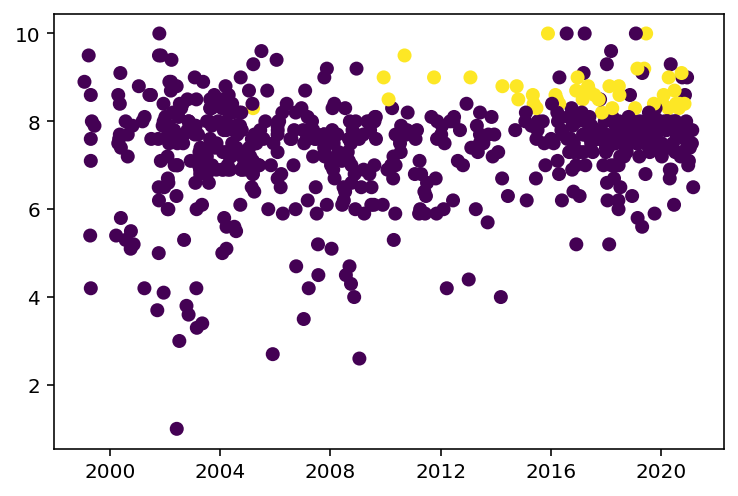

In [964]:
%matplotlib inline
plt.scatter(y='score',x='revdate',data=df,c='best')
plt.show()

### Words per Review

In [996]:
df['totalwords'] = [len(x.split()) for x in df['review_clean'].tolist()]

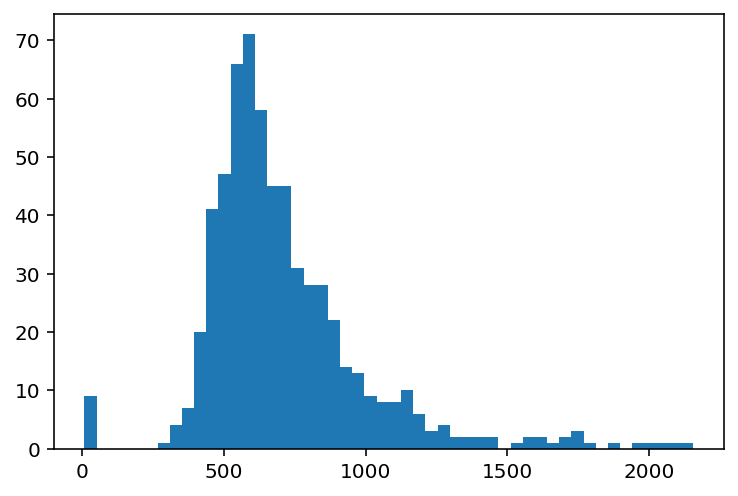

In [1001]:
%matplotlib inline
plt.hist(df['totalwords'],bins=50)
plt.show()

## Pre-processing

### Stop Words

In [1154]:
from sklearn.feature_extraction import text 

my_stop_words = nltk.corpus.stopwords.words('english')
my_stop_words.extend(nonwords)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Lemmatize
**Lemmatizing could be tricky since many common words can be used within artist names (tribe called quest becomes tribe call**

In [966]:
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])
spacy_lemmatize = lambda x: " ".join([token.lemma_ for token in nlp(x)])

In [967]:
df["review_lem"] = df["review_clean"].apply(spacy_lemmatize)
df.head(2)

,Unnamed: 0,artist,album,score,genre,review,othercat2,best,review_clean,othercat_clean,artist_clean,album_clean,revdate,review_lem
0,0,Sam Gendel,Fresh Bread,6.5,Jazz,"Fifty-two tracks deep, this archival compendiu...","Sam Gendel, Jay Balfour, Sam Gendel, cover...",0,fiftytwo tracks deep this archival compendium ...,"sam gendel, jay balfour, sam gendel, cover...",sam gendel,fresh bread,2021-03-04,fiftytwo track deep this archival compendium m...
1,1,Femi Kuti / Made Kuti,Legacy +,7.8,Global,"On the duo’s generation-spanning double album,...","Femi Kuti, Made Kuti, Joey Akan, Global, F...",0,on the duo’s generationspanning double album f...,"femi kuti, made kuti, joey akan, global, f...",femi kuti / made kuti,legacy +,2021-02-20,on the duo ’s generationspanne double album fe...


**for future ref - everything that is capitalized could be a named entity**

In [968]:
df.review_lem[135]

'the minneapolis synthpop band team up with a berlinbased orchestra in an attempt to reckon with the trial of our time you have to admire poliça ’s willingness to break their own mold in   with two album \' worth of hazy breakup song under their belt the minneapolis fivepiece abruptly pivot into political consciousness and trade some of their rock instinct in for a smattering of pop motif the result album united crusher falter at time but it be a goodfaith effort to engage with the national mood poliça read the room and respond accordingly poliça ’s late album be the product of another reinvention in merge with s t a r g a z e the berlinbase orchestral collective lead by conductor andré de ridder they ’ve more than double their lineup with all those extra body in the room the deep dark chasm that fracture their early work separate singer channy leaneagh ’s voice from producer ryan olson ’s rumble synth begin to fill in the result sound feel new to be sure but mostly in the sense that i

In [969]:
#df['review_clean']=df['review_clean'].str.replace('"', '')
df['review_clean2'] = df['review_clean'].map(lambda x: re.sub(r'\W', ' ', x))

In [970]:
df.review_clean2[135]

'the minneapolis synthpop band teams up with a berlinbased orchestra in an attempt to reckon with the trials of our time you have to admire poliça s willingness to break their own mold in  with two albums  worth of hazy breakup songs under their belts the minneapolis fivepiece abruptly pivoted into political consciousness and traded some of their rock instincts in for a smattering of pop motifs the resulting album united crushers faltered at times but it was a goodfaith effort to engage with the national mood poliça read the room and responded accordingly poliça s latest album is the product of another reinvention in merging with s t a r g a z e the berlinbased orchestral collective led by conductor andré de ridder they ve more than doubled their lineup with all those extra bodies in the room the deep dark chasms that fractured their earlier work separating singer channy leaneagh s voice from producer ryan olson s rumbling synths begin to fill in the resulting sound feels new to be sur

### Lets start with a basic approach:
**1. TFIDF**<br>
**2. Cosine Similarity**<br>
**3. Check recommendations**

In [974]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [975]:
my_stop_words

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

**TFIDF**

In [976]:
tfidf = TfidfVectorizer(analyzer='word', stop_words=my_stop_words)

**apply matrix to clean text (still contains caps)**

In [977]:
rev_matrix= tfidf.fit_transform(df['review_clean2'])

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['2021', 'accessibility', 'advertising', 'albums', 'back', 'bandcamp', 'berlin', 'best', 'breakthroughs', 'buy', 'careers', 'chicago', 'contact', 'content', 'critical', 'features', 'festival', 'galleries', 'grammys', 'guides', 'help', 'home', 'influences', 'liner', 'lists', 'longform', 'masthead', 'music', 'new', 'news', 'notes', 'paris', 'photo', 'picks', 'pitch', 'podcast', 'radio', 'records', 'results', 'reviews', 'rising', 'sign', 'skip', 'staff', 'sunday', 'tracks', 'video'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


In [978]:
rev_matrix.shape

(624, 33467)

In [979]:
rev_matrix

<624x33467 sparse matrix of type '<class 'numpy.float64'>'
	with 203724 stored elements in Compressed Sparse Row format>

In [980]:
# take a peek at the each review and words

print('Sparse Matrix')
# A compressed version; the "sparse" matrix.
print(type(rev_matrix))
#print(rev_matrix)[0][0]

Sparse Matrix
<class 'scipy.sparse.csr.csr_matrix'>


In [981]:
# change to array for dataframe 

print ('Matrix')
rev_matrix_arr = rev_matrix.toarray()
print(type(rev_matrix_arr))
print(rev_matrix_arr)

Matrix
<class 'numpy.ndarray'>
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


### doc word dataframe

In [982]:
pd.DataFrame(rev_matrix_arr, columns=tfidf.get_feature_names())

,aa,aaahk,aaahs,aacm,aahs,aaly,aap,aaron,aarp,aarset,...,ólafur,órgãos,öyster,ørnes,øya,übergenre,überhip,überinfluence,風物詩,옛날이야기
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
619,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
620,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
621,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
622,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### cosine similarity

In [983]:
cosine_similarities = cosine_similarity(rev_matrix)

In [984]:
len(cosine_similarities)

624

In [985]:
similarities = {}

In [986]:
for i in range(len(cosine_similarities)):
    
    # Sort each element in cosine_similarities and get the indexes of the artists
    similar_indices = cosine_similarities[i].argsort()[:-50:-1] 
    
    # Store in similarities each name of the 10 most similar artists
    # Keep the first one as the main search item - and then the remaining similar artists 
    similarities[df['album'].iloc[i]] = [(cosine_similarities[i][x], df['album'][x], df['artist'][x]) for x in similar_indices][0:]

**Enter an album name to get the similarity scores of teh album**

In [987]:
print(similarities['The Secret of Letting Go'])
#print(similarities.values()[0].keys()[0])

[(0.9999999999999996, 'The Secret of Letting Go', 'Lamb'), (0.06846727156342053, 'Real Enemies', "Darcy James Argue's Secret Society"), (0.06781432016720734, 'Report from Iron Mountain', 'Date Course Pentagon Royal Garden'), (0.06581666187247741, 'Offering: Live at Temple University', 'John Coltrane'), (0.06393073100926769, 'Berlin Serengeti', 'Radio Citizen'), (0.061324277643448555, 'Lady Day: The Master Takes and Singles', 'Billie Holiday'), (0.059920291420570246, 'David Axelrod', 'David Axelrod'), (0.05901962290771342, '12 (+1) Imaginary Views', 'Ellery Eskelin'), (0.058826106747715726, 'Same As It Never Was', 'The Herbaliser'), (0.057904409452372685, 'The Golden Age of Apocalypse', 'Thundercat'), (0.0578411858991793, 'Day Breaks', 'Norah Jones'), (0.05752766695329272, 'Love In a Time of Madness', 'José James'), (0.056934887838134565, 'Madness, Love and Mysticism', 'John Zorn'), (0.055852345830604465, 'Miles at the Fillmore - Miles Davis 1970: The Bootleg Series Vol. 3', 'Miles Davi

In [988]:
import itertools

# Initialize limit  
N = 1
    
# Using islice() + items()  
# Get first N items in dictionary  
out = dict(itertools.islice(similarities.items(), N))  
        
# printing result   
print("Dictionary limited by K is : " + str(out))

Dictionary limited by K is : {'Fresh Bread': [(1.0, 'Fresh Bread', 'Sam Gendel'), (0.46474001753483724, '4444', 'Sam Gendel'), (0.302710525424612, 'Satin Doll', 'Sam Gendel'), (0.21473989942773145, 'WILKES', 'Sam Wilkes'), (0.0765234820199772, 'Actual Presence', 'Carlos Niño & Friends'), (0.07470343177983821, 'Offering: Live at Temple University', 'John Coltrane'), (0.07354593125227041, 'Both Directions at Once: The Lost Album', 'John Coltrane'), (0.07349388835402751, 'Unemployed', 'Alog'), (0.07091052597952863, 'A Jackson in Your House/Message to Our Folks', 'Art Ensemble of Chicago'), (0.06982293347531608, '12 (+1) Imaginary Views', 'Ellery Eskelin'), (0.06750994357029944, 'Incommunicado', 'Kammerflimmer Kollektief'), (0.06741295621322788, 'Blobscape', 'Geoff Farina'), (0.06681916121647749, 'So Glossy and So Thin', 'Jackson / Baker / Kirshner'), (0.06578804928706278, 'Cannonball!', 'Sen Morimoto'), (0.06509202780966578, 'Sketches of Spain: Legacy Edition', 'Miles Davis'), (0.06429922

### content based recommendation

In [989]:
class ContentBasedRecommender:
    def __init__(self, matrix):
        self.matrix_similar = matrix

    def _print_message(self, album, recom_album,artist):
        rec_items = len(recom_album)        
        
        #print(f'The {rec_items} recommended albums for {album} are:')
        #print(f"{album} by {artist} ") # with {album[0][0]} similarity score")  # if can add artist sim score        
        #print(f'The {rec_items} recommended albums are:') # if can add artist search title
        
        for i in range(rec_items):
            if i==0:
                #print(f"Matched Album Number {i+1}:")
                print(f"{recom_album[i][1]} by {artist}") # with {round(recom_album[i][0],3)} similarity score")  # if can add artist sim score
                print("--------------------")
            else:    
                print(f"Recommended album based on matched (above) {i}:")            
                print(f"{recom_album[i][1]} by {recom_album[i][2]} with {round(recom_album[i][0], 3)} similarity score") 
                print("--------------------")
        
    def recommend(self, recommendation):
        artist = recommendation['artist']
        # Get album to find recommendations for
        album = recommendation['album']
        # Get number of albums to recommend
        similar_albums = recommendation['similar_albums']
        # Get the number of albums most similars from matrix similarities
        recom_album = self.matrix_similar[album][:similar_albums]
        # print each item
        self._print_message(album=album, recom_album=recom_album,artist=artist)

**instantiate rec function**

In [990]:
recommedations = ContentBasedRecommender(similarities)

In [991]:
def artsimrec(art,artmatch=1,simalb=0):
    # get list of indeces containing the chosen word that's in the review text
    _a= df.index[df['review_clean2'].str.contains(art,na=False)]
    # get only # of keyword matches requested by user
    a=_a[:artmatch]
    
    if a.empty:
        return 'not found'
    
    # if the keyword shows up in more than one review get requested # of recs for each artist that is mentioned    
    else: # len(a)>1:
        print(f"The number of reviews containing {art} are: {len(_a)}") 
        print(f"User requested {len(a)} Matches")
        print(f"User requested {simalb} Recommended albums per Match")
        print("--------------------")
        
        for k,j in enumerate(a):
            print(f"Matched Album Number {k+1}:")
            recommendation = {
               "artist": df['artist'].iloc[j],
               "album": df['album'].iloc[j],
               "similar_albums": simalb+1 # add +1 to obtain the right number of similar albums
            }
            recommedations.recommend(recommendation)


In [994]:
artsimrec('ramones',10,3)

The number of reviews containing ramones are: 1
User requested 1 Matches
User requested 3 Recommended albums per Match
--------------------
Matched Album Number 1:
Piano Nights by Bohren & Der Club of Gore
--------------------
Recommended album based on matched (above) 1:
Dolores by Bohren & Der Club of Gore with 0.27 similarity score
--------------------
Recommended album based on matched (above) 2:
Geisterfaust by Bohren & Der Club of Gore with 0.234 similarity score
--------------------
Recommended album based on matched (above) 3:
The Cellar Door Sessions 1970 by Miles Davis with 0.081 similarity score
--------------------


## Topic Modeling

### Get DF with Review only

In [1016]:
df_rev = df['review_lem']
df_rev.head(3)

0    fiftytwo track deep this archival compendium m...
1    on the duo ’s generationspanne double album fe...
2    these live set between the saxophonist and pia...
Name: review_lem, dtype: object

In [1017]:
# Import TfidfVectorizer and NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF    

### Start with Genre Topics

In [1155]:
# Makes sense to add words like 'jazz' to stopwords

stopadd = ['band','time','get','take','work','detail','familiar','also','miles','mile','davis','coltrane','song','year','way','instrument','minute']
my_stop_words.extend(stopadd)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### NMF Model

In [1156]:
# Create a function to model topics using NMF
def nmf_it(data, mindf, maxdf, n_components, n_top_words, stop_list):
    '''Fits an NMF model and prints top words for each topic.
    
    Parameters:
        data: DataFrame/Series containing only raw texts
        n_samples: number of texts to sample from data
        n_features: length of TF-IDF vectors to calculate
        n_components: number of topics to model
        n_top_words: number of words to print for each topic, ranked by
            frequency
        stop_list: your list of stopwords to remove
    '''
    
    # Get sample of data
    #data_samples = data.sample(n_samples, random_state=1)
    
    # Instantiate and fit TfidfVectorizer
    tfidf_vectorizer = TfidfVectorizer(max_df=maxdf, min_df=mindf,
                                       # max_features=n_features,
                                       stop_words=my_stop_words)

    tfidf = tfidf_vectorizer.fit_transform(data) #(data_samples)
    
    # Fit the NMF model
    nmf = NMF(n_components=n_components, random_state=1, alpha=.1, 
              l1_ratio=.5).fit(tfidf)

    # View top words for each topic
    print("\nTopics in NMF model (Frobenius norm):")
    tfidf_feature_names = tfidf_vectorizer.get_feature_names()
    
    for topic_idx, topic in enumerate(nmf.components_):
        message = "Topic #{}: ".format(topic_idx+1)
        message += " ".join([tfidf_feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    
    return tfidf, nmf

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [1157]:
# View top 10 words for 20 topics
tfidf, nmf = nmf_it(df_rev,0.08,0.80,20,10,my_stop_words)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['2021', 'accessibility', 'advertising', 'albums', 'back', 'bandcamp', 'berlin', 'best', 'breakthroughs', 'buy', 'careers', 'chicago', 'contact', 'content', 'critical', 'features', 'festival', 'galleries', 'grammys', 'guides', 'help', 'home', 'influences', 'liner', 'lists', 'longform', 'masthead', 'music', 'new', 'news', 'notes', 'paris', 'photo', 'picks', 'pitch', 'podcast', 'radio', 'records', 'results', 'reviews', 'rising', 'sign', 'sk


Topics in NMF model (Frobenius norm):
Topic #1: record track make new much come seem even feel play
Topic #2: nt really bad disc ca even anyone probably know think
Topic #3: jame singer love contemporary end last pop tribute true stay
Topic #4: rap hiphop beat root flow production producer good underground say
Topic #5: dj mix beat hiphop series cut break disc collaboration track
Topic #6: jazz free modern player scene william tradition structure chord trumpet
Topic #7: parker william brown quartet musician jazz freedom improvisation suite new
Topic #8: group pianist ensemble composition saxophonist player composer performance jazz trumpeter
Topic #9: vocal drum shine synth machine almost harmony experimental go pop
Topic #10: black african people life child power south american experience man
Topic #11: sun city space strange earth noise jazz world reissue vision
Topic #12: blue kind singer world new love state john whose jazz
Topic #13: duo session improvise pair collaboration retur

### Some ideas:
- part of speech (POS) tagging: remove Named Entities to focus on genre
- add specific terms to stoplist

### POS tagging

In [1117]:
# Let's create a function to pull out nouns from a string of text
from nltk import word_tokenize, pos_tag

def nouns(text):
    '''Given a string of text, tokenize the text and pull out only the nouns.'''
    is_noun = lambda pos: pos[:2] in ('NN','NNS','NNP','NNPS') # == 'NN'
    tokenized = word_tokenize(text)
    all_nouns = [word for (word, pos) in pos_tag(tokenized) if is_noun(pos)] 
    return ' '.join(all_nouns)

In [1066]:
df_genre_nouns = pd.DataFrame(df['review_lem'].apply(nouns))
df_genre_nouns.head(2)

,review_lem
0,track deep compendium catchall fact chance hoo...
1,duo ’ s generationspanne album fela lead spiri...


In [1158]:
# View top 10 words for 20 topics
tfidf, nmf = nmf_it(df['review_lem'],0.08,0.80,20,10,my_stop_words)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['2021', 'accessibility', 'advertising', 'albums', 'back', 'bandcamp', 'berlin', 'best', 'breakthroughs', 'buy', 'careers', 'chicago', 'contact', 'content', 'critical', 'features', 'festival', 'galleries', 'grammys', 'guides', 'help', 'home', 'influences', 'liner', 'lists', 'longform', 'masthead', 'music', 'new', 'news', 'notes', 'paris', 'photo', 'picks', 'pitch', 'podcast', 'radio', 'records', 'results', 'reviews', 'rising', 'sign', 'sk


Topics in NMF model (Frobenius norm):
Topic #1: record track make new much come seem even feel play
Topic #2: nt really bad disc ca even anyone probably know think
Topic #3: jame singer love contemporary end last pop tribute true stay
Topic #4: rap hiphop beat root flow production producer good underground say
Topic #5: dj mix beat hiphop series cut break disc collaboration track
Topic #6: jazz free modern player scene william tradition structure chord trumpet
Topic #7: parker william brown quartet musician jazz freedom improvisation suite new
Topic #8: group pianist ensemble composition saxophonist player composer performance jazz trumpeter
Topic #9: vocal drum shine synth machine almost harmony experimental go pop
Topic #10: black african people life child power south american experience man
Topic #11: sun city space strange earth noise jazz world reissue vision
Topic #12: blue kind singer world new love state john whose jazz
Topic #13: duo session improvise pair collaboration retur

In [1070]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

In [1159]:
# CHANGE PARAMS if you need to
# Vectorize the text sample
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, min_df=0.08,
                                   stop_words=my_stop_words)

tfidf = tfidf_vectorizer.fit_transform(df['review_lem'])

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['2021', 'accessibility', 'advertising', 'albums', 'back', 'bandcamp', 'berlin', 'best', 'breakthroughs', 'buy', 'careers', 'chicago', 'contact', 'content', 'critical', 'features', 'festival', 'galleries', 'grammys', 'guides', 'help', 'home', 'influences', 'liner', 'lists', 'longform', 'masthead', 'music', 'new', 'news', 'notes', 'paris', 'photo', 'picks', 'pitch', 'podcast', 'radio', 'records', 'results', 'reviews', 'rising', 'sign', 'sk

In [1160]:
# Instantiate the KMeans model and visualizer
kmeans = KMeans(random_state=1)
visualizer = KElbowVisualizer(kmeans, k=(5, 20), metric='silhouette')

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


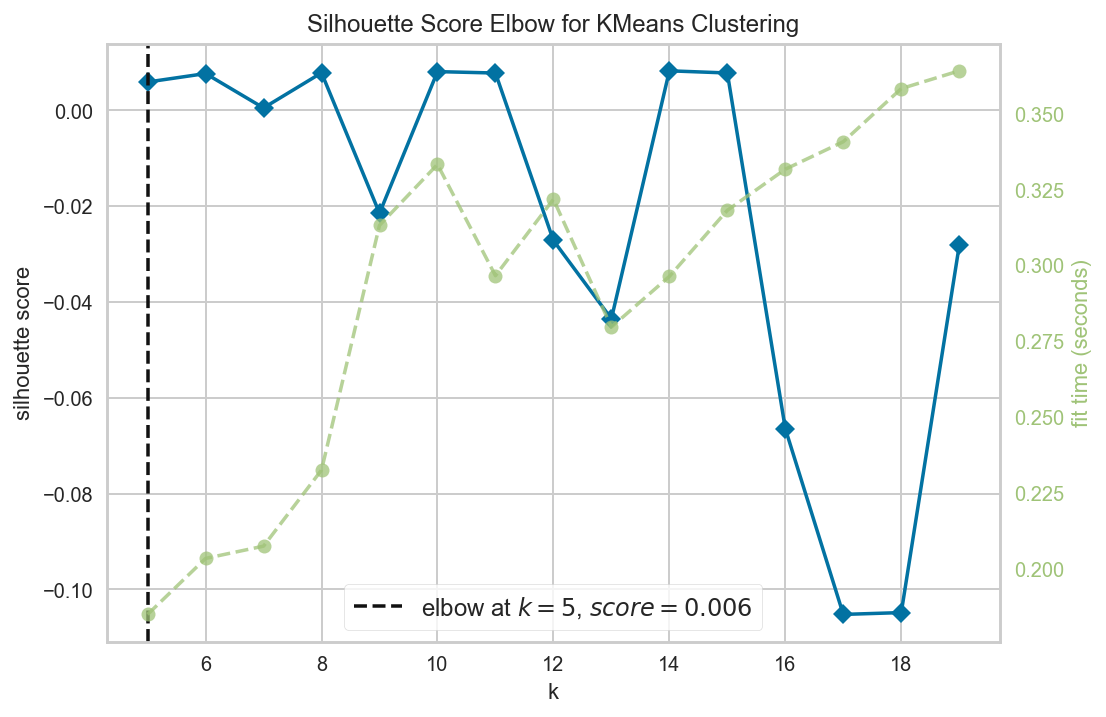

In [1161]:
# Fit the visualizer and plot the results
visualizer.fit(tfidf)       
visualizer.show(outpath='topics.png', dpi=300)

### Try Nouns only @ k=13

In [1162]:
tfidf, nmf = nmf_it(df_genre_nouns['review_lem'],0.15,0.65,13,10,my_stop_words)


Topics in NMF model (Frobenius norm):
Topic #1: piece player solo performance composition composer john saxophonist part note
Topic #2: hiphop sample beat producer production break nothing artist mood funk
Topic #3: guitar rock noise solo play thing start lead melody tone
Topic #4: drum bass percussion beat rhythm funk groove title moment horn
Topic #5: group moment debut member rock lead result percussion drummer saxophonist
Topic #6: tune melody people theme label bit chord genre beat play
Topic #7: piano pianist chord note kind hand melody line composition space
Topic #8: trio drummer moment section line title tone feel bassist member
Topic #9: life world man soul singer day love people thing career
Topic #10: studio session recording version something kind set producer idea release
Topic #11: mix series release set course funk bit start version head
Topic #12: city york part home scene room man feel life beat
Topic #13: voice word string production idea sense feature debut feel bi

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['2021', 'accessibility', 'advertising', 'albums', 'back', 'bandcamp', 'berlin', 'best', 'breakthroughs', 'buy', 'careers', 'chicago', 'contact', 'content', 'critical', 'features', 'festival', 'galleries', 'grammys', 'guides', 'help', 'home', 'influences', 'liner', 'lists', 'longform', 'masthead', 'music', 'new', 'news', 'notes', 'paris', 'photo', 'picks', 'pitch', 'podcast', 'radio', 'records', 'results', 'reviews', 'rising', 'sign', 'sk

**See some topics/genres emerge. Try LDA and see if any better. We may have to resort to selecting key words to get subgenres**

### LDA model

In [1123]:
# Import countVectorizer and LDA
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation    

In [1163]:
def lda_it(data,mindf,maxdf,n_components,n_top_words,stop_list):
    '''Fits an LDA model and prints top words for each topic.
    
    Parameters:
        data: DataFrame/Series containing only raw texts
        n_samples: number of texts to sample from data
        n_features: length of TF-IDF vectors to calculate
        n_components: number of topics to model
        n_top_words: number of words to print for each topic, ranked by
            frequency
        stop_list: your list of stopwords to remove
    '''
        
    
    # Get sample of data
    #data_samples = data.sample(n_samples, random_state=1)
    
    # Instantiate and fit TfidfVectorizer
    count_vectorizer = CountVectorizer(max_df=maxdf, min_df=mindf,                                       
                                       stop_words=my_stop_words)

    counts = count_vectorizer.fit_transform(data)
    
    # Fit the LDA model
    lda = LatentDirichletAllocation(n_components=n_components, 
                                    max_iter=5,                                    
                                    random_state=42).fit(counts)

    # View top words for each topic
    print("\nTopics in LDA model (Frobenius norm):")
    counts_feats = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(lda.components_):
        message = "Topic #{}: ".format(topic_idx+1)
        message += " ".join([counts_feats[i] for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    
    return counts, lda

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [1164]:
lda_it(df_genre_nouns['review_lem'],0.15,0.65, 13, 10, my_stop_words)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['2021', 'accessibility', 'advertising', 'albums', 'back', 'bandcamp', 'berlin', 'best', 'breakthroughs', 'buy', 'careers', 'chicago', 'contact', 'content', 'critical', 'features', 'festival', 'galleries', 'grammys', 'guides', 'help', 'home', 'influences', 'liner', 'lists', 'longform', 'masthead', 'music', 'new', 'news', 'notes', 'paris', 'photo', 'picks', 'pitch', 'podcast', 'radio', 'records', 'results', 'reviews', 'rising', 'sign', 'sk


Topics in LDA model (Frobenius norm):
Topic #1: performance york part saxophonist show saxophone art solo idea musician
Topic #2: guitar rock solo melody noise thing drum moment project play
Topic #3: tune session thing release studio version solo bit man something
Topic #4: life world man people voice release day name john home
Topic #5: group piano composition note composer player pianist play solo set
Topic #6: beat hiphop drum sample bass break producer rhythm production moment
Topic #7: piece solo player chord moment john play melody place drum
Topic #8: studio recording idea cover piece sense piano kind something note
Topic #9: trio piece section piano composition part player release series material
Topic #10: city part place feature percussion solo space groove composition scene
Topic #11: thing bass rhythm piano section funk something title point label
Topic #12: voice soul singer love pop day line artist man mix
Topic #13: group percussion release bass sax something moment fe

(<624x130 sparse matrix of type '<class 'numpy.int64'>'
 	with 19164 stored elements in Compressed Sparse Row format>,
 LatentDirichletAllocation(max_iter=5, n_components=13, random_state=42))

### Use Genre List from MusicBrainz to match keywords in reviews

In [1175]:
mbcsv = open('/Users/chrischan/Documents/02_Class/Metis/bootcamp/githubrepo/Metis_proj5/data/mbrainz_genres.csv', 'r')
mbread = mbcsv.read()
print(mbread)

acid house,
acid jazz,
acid rock,
acid techno,
acoustic blues,
acoustic rock,
afoxê,
afrobeat,
alternative country,
alternative dance,
alternative folk,
alternative hip hop,
alternative metal,
alternative pop,
alternative punk,
alternative rock,
ambient,
ambient dub,
ambient house,
ambient techno,
americana,
anarcho-punk,
aor,
arena rock,
art pop,
art punk,
art rock,
atmospheric black metal,
audiobook,
avant-garde,
avant-garde jazz,
avant-garde metal,
avant-garde pop,
avant-prog,
bachata,
ballad,
barbershop,
bardcore,
baroque,
bass house,
beat music,
bebop,
bhangra,
big band,
big beat,
black metal,
blackened death metal,
blackgaze,
bleep techno,
blue-eyed soul,
bluegrass,
blues,
blues rock,
bolero,
bolero son,
bongo flava,
boogie rock,
boogie-woogie,
boom bap,
bossa nova,
bounce,
breakbeat,
breakbeat hardcore,
breakcore,
breaks,
britpop,
broken beat,
brostep,
brutal death metal,
bubblegum pop,
cajun,
calypso,
candombe,
canterbury scene,
cantopop,
carnatic classical,
celtic,
celtic punk

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [1178]:
_mblist = mbread.split(",")
mbcsv.close()

mblist = []
for element in _mblist:
    mblist.append(element.strip())

mblist.pop() # last element was blank
print(mblist)

['acid house', 'acid jazz', 'acid rock', 'acid techno', 'acoustic blues', 'acoustic rock', 'afoxê', 'afrobeat', 'alternative country', 'alternative dance', 'alternative folk', 'alternative hip hop', 'alternative metal', 'alternative pop', 'alternative punk', 'alternative rock', 'ambient', 'ambient dub', 'ambient house', 'ambient techno', 'americana', 'anarcho-punk', 'aor', 'arena rock', 'art pop', 'art punk', 'art rock', 'atmospheric black metal', 'audiobook', 'avant-garde', 'avant-garde jazz', 'avant-garde metal', 'avant-garde pop', 'avant-prog', 'bachata', 'ballad', 'barbershop', 'bardcore', 'baroque', 'bass house', 'beat music', 'bebop', 'bhangra', 'big band', 'big beat', 'black metal', 'blackened death metal', 'blackgaze', 'bleep techno', 'blue-eyed soul', 'bluegrass', 'blues', 'blues rock', 'bolero', 'bolero son', 'bongo flava', 'boogie rock', 'boogie-woogie', 'boom bap', 'bossa nova', 'bounce', 'breakbeat', 'breakbeat hardcore', 'breakcore', 'breaks', 'britpop', 'broken beat', 'b

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [1137]:
from gensim.corpora.dictionary import Dictionary

def vectorize_vis(data, min_df,max_df):
    vec = CountVectorizer(stop_words=my_stop_words, min_df=min_df, max_df=max_df) #, ngram_range=(1, 3)
    doc_word = vec.fit_transform(data)
    feature_names = vec.get_feature_names()
    id2word = dict((v, k) for k, v in vec.vocabulary_.items())
    dictionary = Dictionary([feature_names])
    
    return doc_word, feature_names, id2word, dictionary

In [1138]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()

def lda_vis(doc_word, feature_names, id2word, dictionary, num_topics):
    corpus = matutils.Sparse2Corpus(doc_word.transpose())
    model = models.LdaModel(corpus=corpus, num_topics=num_topics, id2word=id2word, passes=5, random_state=42)    
    topics = model.print_topics(num_words=50)
    for n, topic in topics:
        print("\nTopic ", n)
        print(topic)

    vis_data = pyLDAvis.gensim.prepare(model, corpus, dictionary)
    return vis_data

In [1147]:
doc_word, feature_names, id2word, dictionary = vectorize_vis(df_genre_nouns['review_lem'], 0.10,.75)
vis_data = lda_vis(doc_word, feature_names, id2word, dictionary, 10)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['2021', 'accessibility', 'advertising', 'albums', 'back', 'bandcamp', 'berlin', 'best', 'breakthroughs', 'buy', 'careers', 'chicago', 'contact', 'content', 'critical', 'features', 'festival', 'galleries', 'grammys', 'guides', 'help', 'home', 'influences', 'liner', 'lists', 'longform', 'masthead', 'music', 'new', 'news', 'notes', 'paris', 'photo', 'picks', 'pitch', 'podcast', 'radio', 'records', 'results', 'reviews', 'rising', 'sign', 'sk


Topic  0
0.027*"track" + 0.023*"record" + 0.021*"thing" + 0.020*"sound" + 0.018*"guitar" + 0.015*"group" + 0.014*"rock" + 0.014*"percussion" + 0.014*"moment" + 0.014*"part" + 0.013*"voice" + 0.013*"place" + 0.013*"piece" + 0.013*"idea" + 0.012*"melody" + 0.012*"word" + 0.011*"project" + 0.011*"musician" + 0.011*"feel" + 0.011*"improvisation" + 0.010*"scene" + 0.010*"drum" + 0.009*"cover" + 0.009*"feature" + 0.009*"point" + 0.009*"player" + 0.009*"sense" + 0.008*"name" + 0.008*"city" + 0.008*"duo" + 0.008*"play" + 0.007*"folk" + 0.007*"solo" + 0.007*"harmony" + 0.007*"use" + 0.007*"horn" + 0.007*"something" + 0.007*"debut" + 0.007*"john" + 0.007*"star" + 0.007*"pop" + 0.007*"collaborator" + 0.007*"room" + 0.006*"note" + 0.006*"lead" + 0.006*"composition" + 0.006*"move" + 0.006*"share" + 0.006*"result" + 0.006*"line"

Topic  1
0.050*"track" + 0.031*"sound" + 0.020*"piano" + 0.019*"group" + 0.016*"pianist" + 0.015*"trio" + 0.014*"record" + 0.014*"moment" + 0.014*"sense" + 0.014*"solo" + 

In [1148]:
pyLDAvis.display(vis_data)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
lsi = models.LsiModel(corpus_tfidf, id2word=dictionary, num_topics=500)

index = similarities.MatrixSimilarity(lsi[corpus])

text_input = 'Franconia Amber'

def get_beer_keywords(text_input):
    input_beer_keywords = []
    for item in sorted(corpus_tfidf[beers[beers.name == text_input].index[0]], key = lambda x: -x[1])[:5]:
        input_beer_keywords.append(dictionary[item[0]])
    return input_beer_keywords

beers['keywords'] = beers.name.map(get_beer_keywords)
get_beer_keywords(text_input)

def get_similar_beers(text_input):
    try:
        doc = documents[beers[beers.name == text_input].index[0]]
        beer_name_inputted = 1
    except IndexError:
        doc = text_input
        beer_name_inputted = 0
    vec_bow = dictionary.doc2bow(doc.lower().split())
    vec_lsi = lsi[vec_bow]

    sims = index[vec_lsi]
    similar_beers = []
    for beer in sorted(enumerate(sims), key = lambda x: -x[1])[beer_name_inputted:beer_name_inputted+5]:
        similar_beers.append((beer[0],beer[1]))

    return similar_beers

beers['similar_beers'] = beers.name.map(get_similar_beers)
get_similar_beers(text_input)

similar_beers = beers.similar_beers.iloc[0]

def get_recs_from_input(text_input):
    beer_name_inputted = True

    similar_beer_ids = list(beers[beers.name == text_input].similar_beers)
    similar_beers = [beer[0] for beer in similar_beer_ids[0]]
    similar_beers = beers.iloc[similar_beers]
    return (similar_beers ,beer_name_inputted)


get_recs_from_input(text_input)[0]

### Topic Modeling

In [805]:
def lsa(doc_word, feature_names, num_topics):
    model = TruncatedSVD(num_topics)
    doc_topic = model.fit_transform(doc_word)
    for ix, topic in enumerate(model.components_):
        print("\nTopic ", ix)
        print(", ".join([feature_names[i] for i in topic.argsort()[:-21:-1]]))

def nmf(doc_word, feature_names, num_topics):
    model = NMF(num_topics)
    doc_topic = model.fit_transform(doc_word)
    for ix, topic in enumerate(model.components_):
        print("\nTopic ", ix)
        print(", ".join([feature_names[i] for i in topic.argsort()[:-75:-1]]))

def lda(doc_word, feature_names, id2word, num_topics):
    corpus = matutils.Sparse2Corpus(doc_word.transpose())
    model = models.LdaModel(corpus=corpus, num_topics=num_topics, id2word=id2word, passes=5, random_state=42)
    topics = model.print_topics(num_words=50)
    for n, topic in topics:
        print("\nTopic ", n)
        print(topic)
        

def corex(doc_word, feature_names, num_topics):
    words = list(np.asarray(feature_names))
    model = corextopic.Corex(n_hidden=num_topics, words=words, seed=1, max_iter=200)
    model.fit(doc_word, words=words, docs=data) # where data = df["Lemmatized"]
    topics = model.get_topics()
    for n,topic in enumerate(topics):
        topic_words,_ = zip(*topic)
        print('{}: '.format(n) + ','.join(topic_words))
        
def vectorize_2(data, min_df,max_df):
    vec = CountVectorizer(stop_words=my_stop_words,  min_df=min_df , max_df=max_df) #ngram_range=(1, 3)
    doc_word = vec.fit_transform(data)
    feature_names = vec.get_feature_names()
    id2word = dict((v, k) for k, v in vec.vocabulary_.items())
    
    return doc_word, feature_names, id2word        

### NMF with min/max df

In [843]:
data_grg = df_sent_grg["lemmatized"]
#data_pos = df_sent_grg_pos["lemmatized"]

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [871]:
doc_word, feature_names, id2word= vectorize_2(data_grg,.03,.55)
nmf(doc_word, feature_names, 5)


Topic  0
hand, kramer, parent, leave, big, move, point, thank, happen, mean, maybe, walk, life, salad, much, even, laugh, apartment, eat, stop, need, play, door, man, kid, face, sorry, sit, check, father, hear, work, turn, table, god, dinner, hold, arm, use, dad, year, lunch, mother, find, please, ever, nice, money, wear, job, buy, kind, break, fine, mind, try, room, another, chuckle, anymore, clothe, shirt, shake, whole, place, pick, raise, head, heh, plan, live, may, help, people

Topic  1
car, bar, first, space, candy, move, dollar, park, big, people, maybe, pull, lot, even, pay, parking, walk, great, front, head, spot, door, sorry, start, leave, buy, kramer, need, help, turn, mean, hat, away, window, day, wait, stop, try, drive, name, nobody, anything, hear, sure, stand, coat, believe, kid, please, open, run, hospital, twenty, pick, wrong, might, change, excuse, fine, another, minute, doubt, ask, store, susan, father, chair, heh, bother, nice, listen, fall, much, elaine

Topic  2


/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


## LDA with min/max df

In [845]:
from gensim.corpora.dictionary import Dictionary

def vectorize_vis(data, min_df,max_df):
    vec = CountVectorizer(stop_words=my_stop_words, min_df=min_df, max_df=max_df) #, ngram_range=(1, 3)
    doc_word = vec.fit_transform(data)
    feature_names = vec.get_feature_names()
    id2word = dict((v, k) for k, v in vec.vocabulary_.items())
    dictionary = Dictionary([feature_names])
    
    return doc_word, feature_names, id2word, dictionary

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [846]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()

def lda_vis(doc_word, feature_names, id2word, dictionary, num_topics):
    corpus = matutils.Sparse2Corpus(doc_word.transpose())
    model = models.LdaModel(corpus=corpus, num_topics=num_topics, id2word=id2word, passes=5, random_state=42)    
    topics = model.print_topics(num_words=50)
    for n, topic in topics:
        print("\nTopic ", n)
        print(topic)

    vis_data = pyLDAvis.gensim.prepare(model, corpus, dictionary)
    return vis_data

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [868]:
doc_word, feature_names, id2word, dictionary = vectorize_vis(data_grg, 0.03,.65)

vis_data = lda_vis(doc_word, feature_names, id2word, dictionary, 5)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Topic  0
0.010*"elaine" + 0.010*"kramer" + 0.010*"something" + 0.009*"talk" + 0.008*"call" + 0.008*"woman" + 0.008*"happen" + 0.008*"time" + 0.007*"little" + 0.007*"even" + 0.007*"give" + 0.007*"george" + 0.007*"anything" + 0.007*"people" + 0.007*"show" + 0.007*"never" + 0.007*"stop" + 0.007*"need" + 0.007*"great" + 0.006*"mean" + 0.006*"yes" + 0.006*"day" + 0.006*"try" + 0.006*"nothing" + 0.006*"leave" + 0.005*"maybe" + 0.005*"buy" + 0.005*"ask" + 0.005*"nice" + 0.005*"name" + 0.005*"big" + 0.005*"start" + 0.005*"hear" + 0.005*"care" + 0.005*"laugh" + 0.005*"sorry" + 0.005*"friend" + 0.005*"point" + 0.005*"believe" + 0.005*"excuse" + 0.004*"live" + 0.004*"funny" + 0.004*"meet" + 0.004*"lot" + 0.004*"minute" + 0.004*"phone" + 0.004*"wait" + 0.004*"first" + 0.004*"always" + 0.004*"guy"

Topic  1
0.012*"call" + 0.010*"yes" + 0.009*"something" + 0.009*"george" + 0.008*"guy" + 0.008*"big" + 0.008*"little" + 0.008*"try" + 0.008*"wait" + 0.007*"give" + 0.007*"talk" + 0.007*"happen" + 0.006*

In [869]:
pyLDAvis.display(vis_data)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
